# Setup

In [1]:
!source /etc/profile.d/modules.sh
!module load CUDA/11.2
!export PATH=/local/java/cuda-11.2/bin:$PATH
!export LD_LIBRARY_PATH=/local/java/cuda-11.2/lib64:/local/java/cudnn-8.1_for_cuda_11.2/lib64:$LD_LIBRARY_PATH  # this line is needed for it to recognise gpu devices -- run this in the terminal
!export CUDA_HOME=/local/java/cuda-11.2
import os 
import tensorflow as tf
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from keras import backend as K

print(tf.__version__)  # 2.12.0
print(tf.config.list_physical_devices('GPU'))  # should show gpu available


2025-02-10 16:19:40.842059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 16:19:40.923203: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 16:19:40.943680: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 16:19:41.933641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-10 16:19:44.609463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 16:19:44.618125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 16:19:44.618239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Prepare the image pairs

In [2]:
"""
def create_pairs():
    pairs = []
    labels = [] 

    for category in os.listdir(TRAIN_PATH):
        anchor_dir = os.path.join(TRAIN_PATH, category, "anchor")
        positive_dir = os.path.join(TRAIN_PATH, category, "positive")
        negative_dir = os.path.join(TRAIN_PATH, category, "negative")

        anchor_list = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir)]
        positive_list = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir)]
        negative_list = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir)]
        
        for a in anchor_list:
            for p in positive_list:
                pairs.append((a,p))
                labels.append(1)
            for n in negative_list:
                pairs.append((a,n))
                labels.append(0)
    
    # shuffle the dataset 
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)
    
    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs()
"""

TRAIN_PATH = "train_separated"
files = [os.path.join(r,file) for r,d,f in os.walk(TRAIN_PATH) for file in f]
file_size = len(files)
print("Number of images: " + str(file_size))

# shuffle dataset
random.shuffle(files)

def make_instances(files, classes = []):
    labels = []
    for i in range(len(files)):
        file = files[i]
        clazz = file.split("/")[-2]
        
        if classes.count(clazz):
            label = classes.index(clazz)
        else:
            label = len(classes)
            classes.append(clazz)

        labels.append(label)

    return np.array(labels), np.array(classes)

labels, classes = make_instances(files)
CLASSES_SIZE = len(classes)

print(str(CLASSES_SIZE) + " classes: ", classes)
training_files = []
training_labels = []
validation_files = []
validation_labels = []

# extract the training and validation data here 
for label in range(CLASSES_SIZE):
    indexes = np.where(labels == label)[0]

    threshold = len(indexes) * 70 // 100

    training_indexes = indexes[0:threshold]
    training_files_for_class = [files[i] for i in training_indexes]

    training_files.extend(training_files_for_class)
    training_labels.extend([label] * len(training_files_for_class))

    validation_indexes = indexes[threshold:]
    validation_files_for_class = [files[i] for i in validation_indexes]

    validation_files.extend(validation_files_for_class)
    validation_labels.extend([label] * len(validation_files_for_class))
print(len(training_files))
print(len(training_labels))
print(len(validation_files))
print(len(validation_labels))

print(training_files[0:4])
print(training_labels[0:4])

print(validation_files[0:4])
print(validation_labels[0:4])

def create_pairs(x, digit_indices):
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(CLASSES_SIZE)]) - 1
    
    for d in range(CLASSES_SIZE):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, CLASSES_SIZE)
            dn = (d + inc) % CLASSES_SIZE
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(CLASSES_SIZE)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

training_files = np.array(training_files)
training_labels = np.array(training_labels)

validation_files = np.array(validation_files)
validation_labels = np.array(validation_labels)

training_pairs, training_pairs_labels = create_pairs_on_set(training_files, training_labels)
validation_pairs, validation_pairs_labels = create_pairs_on_set(validation_files, validation_labels)


print(len(training_files))
print(len(validation_files))
print(len(training_pairs))
print(len(validation_pairs))


print(training_pairs)  # list of pairs
print(training_pairs_labels)  # 1 if similar, 0 otherwise

Number of images: 96
8 classes:  ['camera' 'alarm_clock' 'mouse' 'pencil_case' 'wallet' 'water_bottle'
 'backpack' 'digital_watch']
64
64
32
32
['train_separated/camera/sony_zv_e10_06.jpg', 'train_separated/camera/zve10kittop_500x.jpg', 'train_separated/camera/20250204_204308.jpg', 'train_separated/camera/20250204_203503.jpg']
[0, 0, 0, 0]
['train_separated/camera/sony_zve10_kit_1.jpg', 'train_separated/camera/design-medium.jpg', 'train_separated/camera/20250204_203501.jpg', 'train_separated/alarm_clock/20250209_201744.jpg']
[0, 0, 0, 1]
64
32
64
32
[['train_separated/camera/sony_zv_e10_06.jpg'
  'train_separated/camera/zve10kittop_500x.jpg']
 ['train_separated/camera/sony_zv_e10_06.jpg'
  'train_separated/water_bottle/s-l400.jpg']
 ['train_separated/camera/zve10kittop_500x.jpg'
  'train_separated/camera/20250204_204308.jpg']
 ['train_separated/camera/zve10kittop_500x.jpg'
  'train_separated/digital_watch/51L5xGWtlnL._AC_UF1000,1000_QL80_.jpg']
 ['train_separated/camera/20250204_204308

# Preprocess the images

In [3]:
def preprocess(image_path):
    # read the file 
    raw = tf.io.read_file(image_path)
    img = tf.io.decode_image(raw, expand_animations=False, channels = 3)
    img = tf.image.resize(img, size = (224, 224), preserve_aspect_ratio=True)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    img = tf.cast(img, tf.float32)/255.0
    return img 

def preprocess_pair(pair):
    imgA = preprocess(pair[0])
    imgB = preprocess(pair[1])
    return (imgA, imgB)

class RandomInvert(tf.keras.layers.Layer):
    def __init__(self, max_value = 255, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        self.max_value = max_value

    def call(self, x):
        if  tf.random.uniform([]) < self.factor:
            x = (self.max_value - x)
        return x

data_augmentation = tf.keras.Sequential([
    RandomInvert(max_value = 1.0),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation((-0.4, 0.4)),
    tf.keras.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=(0., 1.)),
    tf.keras.layers.GaussianNoise(0.005),
    tf.keras.layers.RandomZoom(height_factor=(-0.4, 0.4)),
    tf.keras.layers.RandomContrast(factor=(0.1, 0.9)),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

2025-02-10 16:19:44.667168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 16:19:44.668031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 16:19:44.668203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 16:19:44.668284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

# Hyper parameters

In [4]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATION = 2
MARGIN = 1.0

# Build the training and validation dataset

In [5]:
# split data into training and validation dataset
"""
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.3, random_state=42
)
"""

'\ntrain_pairs, val_pairs, train_labels, val_labels = train_test_split(\n    pairs, labels, test_size=0.3, random_state=42\n)\n'

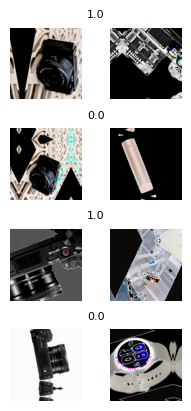

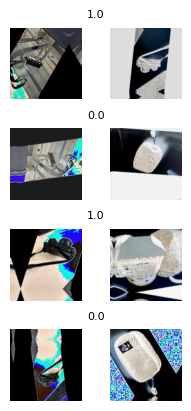

<Figure size 200x400 with 0 Axes>

In [6]:
def build_training_dataset():
    pairs_tensor = tf.convert_to_tensor(training_pairs)
    labels_tensor = tf.convert_to_tensor(training_pairs_labels)
    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    # preprocess the images 
    result = result.map(lambda pair, label: (preprocess_pair(pair), label))
    result = result.batch(BATCH_SIZE_TRAIN)
    result = result.map(lambda pair, y: ((data_augmentation(pair[0], training=True),data_augmentation(pair[1], training=True)), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
    result = result.prefetch(tf.data.AUTOTUNE)
    return result

def build_validation_dataset():
    pairs_tensor = tf.convert_to_tensor(validation_pairs)
    labels_tensor = tf.convert_to_tensor(validation_labels)
    result = tf.data.Dataset.from_tensor_slices((pairs_tensor, labels_tensor))

    # preprocess the images 
    result = result.map(lambda pair, label: (preprocess_pair(pair), label))
    result = result.batch(BATCH_SIZE_VALIDATION)
    result = result.prefetch(tf.data.AUTOTUNE)

    return result 

train_dataset = build_training_dataset()
validation_dataset = build_validation_dataset()

def visualize_dataset(dataset, instances, batch_size, rows_per_image):

    img_size = 1

    fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
    subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
    subfigs = subfigs.flatten()
    row = 0
    for images, labels in dataset.take(instances):

        for i in range(batch_size):

            img_A = (images[0][i].numpy()*255).astype("uint8")
            img_B = (images[1][i].numpy()*255).astype("uint8")
            label = labels[i].numpy()

            axs = subfigs[row % rows_per_image].subplots(1, 2, sharey=True)

            axs[0].imshow(img_A)
            axs[0].axis("off")
            axs[1].imshow(img_B)
            axs[1].axis("off")

            subfigs[row % rows_per_image].suptitle(str(label), fontsize=8)
            row += 1
            if row % rows_per_image == 0:
                fig
                fig = plt.figure(layout='constrained', figsize=(img_size*2, img_size*rows_per_image))
                subfigs = fig.subfigures(rows_per_image, img_size, wspace=0.07)
                subfigs = subfigs.flatten()

visualize_dataset(train_dataset, 1, BATCH_SIZE_TRAIN, 4)

# Calculate euclidean distance

In [7]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_squared = K.sum(K.square(x-y), axis = 1, keepdims= True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Make embedding
embedding is each sub, identical model

In [8]:
def make_embedding():
    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
    
    base_model.trainable = True
    fine_tune_at = len(base_model.layers)-int(len(base_model.layers)*.10)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
          
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs=tf.keras.layers.Dense(64)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model
    

# Build siamese model

In [9]:
def make_siamese_model():
    # create embedding
    embedding = make_embedding()

    # create the same embedding for the two inputs 
    input_a = Input(shape = INPUT_SHAPE, name = "first_image")
    input_b = Input(shape = INPUT_SHAPE, name = "second_image")

    embedding_a = embedding(input_a)
    embedding_b = embedding(input_b)

    # Create the final euclidean distance layer
    output = Lambda(euclidean_distance, name = "distance")([embedding_a, embedding_b])

    return Model([input_a, input_b], output)

In [10]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 second_image (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 64)           2339968     ['first_image[0][0]',            
                                                                  'second_image[0][0]']     

# Contrastive loss

In [11]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(MARGIN - y_pred, 0))
    return (y_true * square_pred + (1 - y_true) * margin_square)

# Compile and train model

In [12]:
class Custom_Precision(tf.keras.metrics.Precision):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)
  
class Custom_Recall(tf.keras.metrics.Recall):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)
  
class Custom_Accuracy(tf.keras.metrics.Accuracy):

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_fix = tf.math.less(y_pred, 0.5) 
        y_pred_fix = tf.cast(y_pred_fix, y_pred.dtype)
       
        return super().update_state(y_true, y_pred_fix, sample_weight)

In [13]:
EPOCHS = 200
model_file = "weights/best_fit.hdf5"
siamese_model.compile(loss=contrastive_loss, 
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=[Custom_Accuracy(), Custom_Precision(), Custom_Recall()]
                      )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 30, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = siamese_model.fit(train_dataset, 
                            steps_per_epoch=math.ceil(len(training_pairs) / BATCH_SIZE_TRAIN), 
                            validation_data=validation_dataset, 
                            epochs = EPOCHS,
                            callbacks=[early_stop, checkpoint])

Epoch 1/200


2025-02-10 16:19:58.132989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-02-10 16:19:58.548449: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-10 16:19:58.548828: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-10 16:19:58.548835: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-02-10 16:19:58.549266: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-10 16:19:58.549294: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


4/8 [==============>...............] - ETA: 0s - loss: 14.6882 - accuracy: 0.5000 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00 

2025-02-10 16:19:58.818588: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/8 [=========================>....] - ETA: 0s - loss: 10.9023 - accuracy: 0.5000 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00
Epoch 1: val_loss improved from inf to 514.05060, saving model to weights/best_fit.hdf5
8/8 [==============================] - 6s 236ms/step - loss: 10.1028 - accuracy: 0.5000 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00 - val_loss: 514.0506 - val_accuracy: 0.0938 - val_custom__precision: 0.0000e+00 - val_custom__recall: 0.0000e+00
Epoch 2/200
6/8 [=====================>........] - ETA: 0s - loss: 1.6583 - accuracy: 0.5000 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00
Epoch 2: val_loss did not improve from 514.05060
8/8 [==============================] - 1s 74ms/step - loss: 1.4220 - accuracy: 0.5000 - custom__precision: 0.0000e+00 - custom__recall: 0.0000e+00 - val_loss: 576.3989 - val_accuracy: 0.0938 - val_custom__precision: 0.0000e+00 - val_custom__recall: 0.0000e+00
Epoch 3/200
7/8 [=========================>.

# Evaluate the model on validation data

In [ ]:
for index, pair in enumerate(validation_pairs):
    imgA, imgB = preprocess_pair(pair)

    # Add batch dimension
    imgA = tf.expand_dims(imgA, axis=0)  # (1, 224, 224, 3)
    imgB = tf.expand_dims(imgB, axis=0)  # (1, 224, 224, 3)

    prediction = siamese_model.predict([imgA, imgB])  
    print(f"Distance: {prediction[0]}")
    print(f"Predicted: {prediction[0] <= 0.5}")
    print(f"Label: {bool(validation_pairs_labels[index])}")

1/1 [==============================] - 0s 15ms/step
Distance: [0.13651505]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 16ms/step
Distance: [0.6898037]
Predicted: [False]
Label: False
1/1 [==============================] - 0s 15ms/step
Distance: [0.36264697]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 15ms/step
Distance: [0.8761265]
Predicted: [False]
Label: False
1/1 [==============================] - 0s 15ms/step
Distance: [0.5408913]
Predicted: [False]
Label: True
1/1 [==============================] - 0s 14ms/step
Distance: [0.4310047]
Predicted: [ True]
Label: False
1/1 [==============================] - 0s 14ms/step
Distance: [0.13069107]
Predicted: [ True]
Label: True
1/1 [==============================] - 0s 14ms/step
Distance: [1.0636468]
Predicted: [False]
Label: False
1/1 [==============================] - 0s 15ms/step
Distance: [0.7413046]
Predicted: [False]
Label: True
1/1 [==============================] - 0s 15ms/s